# Face Generation

In this project, you'll define and train a Generative Adverserial network of your own creation on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **defining new architectures training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset has higher resolution images than datasets you have previously worked with (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed-celeba-small/`.

In [12]:
!pip install torch

Defaulting to user installation because normal site-packages is not writeable


In [1]:
# run this once to unzip the file
!unzip processed-celeba-small.zip

Archive:  processed-celeba-small.zip
replace processed_celeba_small/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [54]:
from glob import glob
from typing import Tuple, Callable, Dict

import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, ToTensor, Resize, Normalize

import tests

In [55]:
data_dir = 'processed_celeba_small/celeba/'

## Data pipeline

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA dataset and contains roughly 30,000 images. 

Your first task consists in building the dataloader. To do so, you need to do the following:
* implement the get_transforms function
* create a custom Dataset class that reads the CelebA data

### Exercise: implement the get_transforms function

The `get_transforms` function should output a [`torchvision.transforms.Compose`](https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html#torchvision.transforms.Compose) of different transformations. You have two constraints:
* the function takes a tuple of size as input and should **resize the images** to the input size
* the output images should have values **ranging from -1 to 1**

In [56]:
from torchvision.transforms import Resize, ToTensor, Normalize, Compose
from typing import Tuple, Callable

def get_transforms(size: Tuple[int, int]) -> Callable:
    """ Transforms to apply to the image."""
    # TODO: edit this function by appening transforms to the below list
    transforms = [Resize(size), 
                  ToTensor(), 
                  Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])]
    
    return Compose(transforms)

### Exercise: implement the DatasetDirectory class


The `DatasetDirectory` class is a torch Dataset that reads from the above data directory. The `__getitem__` method should output a transformed tensor and the `__len__` method should output the number of files in our dataset. You can look at [this custom dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files) for ideas. 

In [57]:
import glob, os
from torchvision.io import read_image
from PIL import Image
import torchvision.transforms as transforms

class DatasetDirectory(Dataset):
    """
    A custom dataset class that loads images from folder.
    args:
    - directory: location of the images
    - transform: transform function to apply to the images
    - extension: file format
    """
    def __init__(self, 
                 directory: str, 
                 transforms: Callable = None, 
                 extension: str = '.jpg'):
        self.directory = directory
        self.transforms = transforms
        self.extension = extension
        self.picture_files = glob.glob(directory + "*" + extension)

    def __len__(self) -> int:
        """ returns the number of items in the dataset """
        # TODO: return the number of elements in the dataset
        return len(self.picture_files)

    def __getitem__(self, index: int) -> torch.Tensor:
        """ load an image and apply transformation """
        # TODO: return the index-element of the dataset
        #print(self.picture_files[index])
        filename = self.picture_files[index]
        img_path = os.path.join(self.directory, filename)
        img = (Image.open(filename))
        transformImage = transforms.ToTensor()(img)
        return transformImage

In [58]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
# run this cell to verify your dataset implementation
dataset = DatasetDirectory(data_dir, get_transforms((64, 64)))
tests.check_dataset_outputs(dataset)

Congrats, your dataset implementation passed all the tests


The functions below will help you visualize images from the dataset.

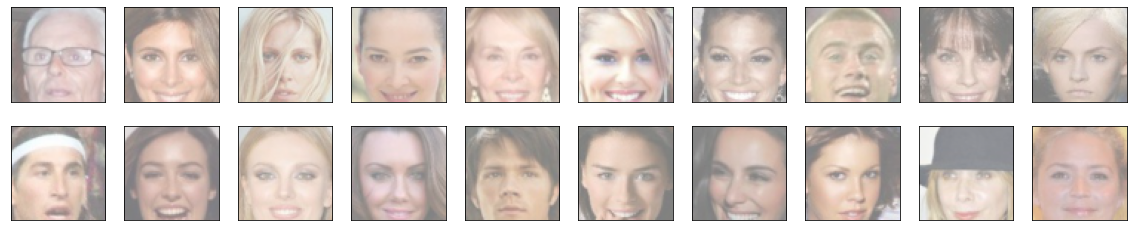

In [59]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""

def denormalize(images):
    """Transform images from [-1.0, 1.0] to [0, 255] and cast them to uint8."""
    return ((images + 1.) / 2. * 255).astype(np.uint8)

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, int(plot_size/2), idx+1, xticks=[], yticks=[])
    img = dataset[idx].numpy()
    img = np.transpose(img, (1, 2, 0))
    img = denormalize(img)
    ax.imshow(img)

## Model implementation

As you know, a GAN is comprised of two adversarial networks, a discriminator and a generator. Now that we have a working data pipeline, we need to implement the discriminator and the generator. 

Feel free to implement any additional class or function.

### Exercise: Create the discriminator

The discriminator's job is to score real and fake images. You have two constraints here:
* the discriminator takes as input a **batch of 64x64x3 images**
* the output should be a single value (=score)

Feel free to get inspiration from the different architectures we talked about in the course, such as DCGAN, WGAN-GP or DRAGAN.

#### Some tips
* To scale down from the input image, you can either use `Conv2d` layers with the correct hyperparameters or Pooling layers.
* If you plan on using gradient penalty, do not use Batch Normalization layers in the discriminator.

In [60]:
from torch.nn import Module
import torch.nn as nn

In [61]:
# from exercise "DCGAN-Training-Solution"

class ConvBlock(nn.Module):
    """
    A convolutional block is made of 3 layers: Conv -> BatchNorm -> Activation.
    args:
    - in_channels: number of channels in the input to the conv layer
    - out_channels: number of filters in the conv layer
    - kernel_size: filter dimension of the conv layer
    - batch_norm: whether to use batch norm or not
    """
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int, batch_norm: bool = True):
        super(ConvBlock, self).__init__()
        
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=2, padding=1, bias=False)
        self.batch_norm = batch_norm
        if self.batch_norm:
            self.bn = nn.BatchNorm2d(out_channels)
        self.activation = nn.LeakyReLU(0.2)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv(x)
        if self.batch_norm:
            x = self.bn(x)
        x = self.activation(x)
        return x

In [62]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # TODO: instantiate the different layers

        # complete init function
        self.conv_dim = 64

        # 64x64 input
        self.conv1 = ConvBlock(3, self.conv_dim, 4, batch_norm=False) # first layer, no batch_norm
        # 32x32 out
        self.conv2 = ConvBlock(self.conv_dim, self.conv_dim*2, 4)
        # 16x16 out
        self.conv3 = ConvBlock(self.conv_dim*2, self.conv_dim*4, 4)
        # 8x8 out
        self.conv4 = ConvBlock(self.conv_dim*4, self.conv_dim*8, 4)
        # 4x4 out
        
#        self.flatten = nn.Flatten()
        # final, fully-connected layer
        self.fc = nn.Linear(self.conv_dim*4*4*4*2, 1)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # all hidden layers + leaky relu activation
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        # flatten
        x = x.view(-1,self.conv_dim*4*4*4*2)
        # final output layer
        x = self.fc(x)     
#        x = x.unsqueeze(0).unsqueeze(2) # to get a torch.Size([1, 1, 1, 1]) object satisfies the tests.check_discriminator(discriminator)
#        print(x)
        return x

In [63]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
# run this cell to check your discriminator implementation
discriminator = Discriminator()
tests.check_discriminator(discriminator)

AssertionError: The discriminator output should be a single score.

### Exercise: create the generator

The generator's job creates the "fake images" and learns the dataset distribution. You have three constraints here:
* the generator takes as input a vector of dimension `[batch_size, latent_dimension, 1, 1]`
* the generator must outputs **64x64x3 images**

Feel free to get inspiration from the different architectures we talked about in the course, such as DCGAN, WGAN-GP or DRAGAN.

#### Some tips:
* to scale up from the latent vector input, you can use `ConvTranspose2d` layers
* as often with Gan, **Batch Normalization** helps with training

In [64]:
# from exercise "DCGAN-Training-Solution"

class DeconvBlock(nn.Module):
    """
    A "de-convolutional" block is made of 3 layers: ConvTranspose -> BatchNorm -> Activation.
    args:
    - in_channels: number of channels in the input to the conv layer
    - out_channels: number of filters in the conv layer
    - kernel_size: filter dimension of the conv layer
    - stride: stride of the conv layer
    - padding: padding of the conv layer
    - batch_norm: whether to use batch norm or not
    """
    def __init__(self, 
                 in_channels: int, 
                 out_channels: int, 
                 kernel_size: int, 
                 stride: int,
                 padding: int,
                 batch_norm: bool = True):
        super(DeconvBlock, self).__init__()
        self.deconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
        self.batch_norm = batch_norm
        if self.batch_norm:
            self.bn = nn.BatchNorm2d(out_channels)
        self.activation = nn.ReLU()
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.deconv(x)
        if self.batch_norm:
            x = self.bn(x)
        x = self.activation(x)
        return x

In [65]:
class Generator(Module):
    def __init__(self, latent_dim: int):
        super(Generator, self).__init__()
        # transpose conv layers
        self.conv_dim = 64
        self.deconv1 = DeconvBlock(latent_dim, self.conv_dim*8, 4, 1, 0)
        self.deconv2 = DeconvBlock(self.conv_dim*8, self.conv_dim*4, 4, 2, 1)
        self.deconv3 = DeconvBlock(self.conv_dim*4, self.conv_dim*2, 4, 2, 1)
        self.deconv4 = DeconvBlock(self.conv_dim*2, self.conv_dim, 4, 2, 1)
        self.deconv5 = nn.ConvTranspose2d(self.conv_dim, 3, 4, stride=2, padding=1)
        self.last_activation = nn.Tanh()
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # TODO: implement the forward method
        x = self.deconv1(x)
        x = self.deconv2(x)
        x = self.deconv3(x)
        x = self.deconv4(x)
        x = self.deconv5(x)
        x = self.last_activation(x)
  
        return x

In [66]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
# run this cell to verify your generator implementation
latent_dim = 128
generator = Generator(latent_dim)
tests.check_generator(generator, latent_dim)

Congrats, your generator implementation passed all the tests


## Optimizer

In the following section, we create the optimizers for the generator and discriminator. You may want to experiment with different optimizers, learning rates and other hyperparameters as they tend to impact the output quality.

### Exercise: implement the optimizers

In [67]:
import torch.optim as optim

# params
lr = 0.0001
beta1=0.5
beta2=0.999 # default value

def create_optimizers(generator: Module, discriminator: Module):
    """ This function should return the optimizers of the generator and the discriminator """
    # TODO: implement the generator and discriminator optimizers
    g_optimizer = optim.Adam(generator.parameters(), lr, [beta1, beta2])
    d_optimizer = optim.Adam(discriminator.parameters(), lr, [beta1, beta2])
    return g_optimizer, d_optimizer

## Losses implementation

In this section, we are going to implement the loss function for the generator and the discriminator. You can and should experiment with different loss function.

Some tips:
* You can choose the commonly used the binary cross entropy loss or select other losses we have discovered in the course, such as the Wasserstein distance.
* You may want to implement a gradient penalty function as discussed in the course. It is not required and the code will work whether you implement it or not.

### Exercise: implement the generator loss

The generator's goal is to get the discriminator to think its generated images (= "fake" images) are real.

In [68]:
def generator_loss(fake_logits):
    """ Generator loss, takes the fake scores as inputs. """
#    return -torch.mean(fake_logits)

    batch_size = fake_logits.size(0)
#    print("batch_size=", batch_size)
#    print("fake_logits=", fake_logits)
    labels = torch.ones(batch_size) # fake labels = 1
#    print("labels=",labels)
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    #print(fake_logits.shape, labels.shape)
    loss = criterion(fake_logits.squeeze(), labels)
    
    return loss

### Exercise: implement the discriminator loss

We want the discriminator to give high scores to real images and low scores to fake ones and the discriminator loss should reflect that.

In [69]:
def discriminator_loss(real_logits, fake_logits):
    """ Discriminator loss, takes the fake and real logits as inputs. """

#    return -real_logits.mean() + fake_logits.mean()

    batch_size = real_logits.size(0)
    # label smoothing
    labels = torch.ones(batch_size)*0.9

    # move labels to GPU if available     
    if train_on_gpu:
        labels = labels.cuda()
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss_real = criterion(real_logits.squeeze(), labels)

    labels_fake = torch.zeros(batch_size) # fake labels = 0
    if train_on_gpu:
        labels_fake = labels_fake.cuda()

    # calculate loss
    #print(fake_logits.shape, labels_fake.shape)
    loss_fake = criterion(fake_logits.squeeze(), labels_fake)
    
    
    return loss_real + loss_fake

### Exercise (Optional): Implement the gradient Penalty

In the course, we discussed the importance of gradient penalty in training certain types of Gans. Implementing this function is not required and depends on some of the design decision you made (discriminator architecture, loss functions).

In [70]:
def gradient_penalty(discriminator, real_samples, fake_samples):
    """ This function enforces """
    # TODO (Optional): implement the gradient penalty
    # Generate random samples between real and fake samples
    alpha = torch.rand(real_samples.size(0), 1, 1, 1).to(device)
    interpolates = (alpha  *real_samples + (1 - alpha)*  fake_samples).requires_grad_(True)

    # Compute the output of the discriminator on the interpolated samples
    disc_interpolates = discriminator(interpolates)

    # Compute the gradients of the discriminator's output with respect to the interpolated samples
    gradients = torch.autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                                    grad_outputs=torch.ones(disc_interpolates.size()).to(device),
                                    create_graph=True, retain_graph=True)[0]

    # Compute the gradient penalty
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()

    return gradient_penalty

## Training


Training will involve alternating between training the discriminator and the generator. You'll use your functions real_loss and fake_loss to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function

### Exercise: implement the generator step and the discriminator step functions

Each function should do the following:
* calculate the loss
* backpropagate the gradient
* perform one optimizer step

In [71]:
def generator_step(batch_size: int, latent_dim: int) -> Dict:
    """ One training step of the generator. """
    # TODO: implement the generator step (foward pass, loss calculation and backward pass)
    
    g_optimizer.zero_grad()
    
    z = np.random.uniform(-1, 1, size=(batch_size, latent_dim, 1, 1))
    z = torch.from_numpy(z).float()
    if train_on_gpu:
        z = z.cuda()
            
    fake_img = generator(z)
    D_out = discriminator(fake_img)
    
    g_loss = generator_loss(D_out)
    g_loss.backward()
    
    g_optimizer.step()
    
    return {'loss': g_loss}


def discriminator_step(batch_size: int, latent_dim: int, real_images: torch.Tensor) -> Dict:
    """ One training step of the discriminator. """
    # TODO: implement the discriminator step (foward pass, loss calculation and backward pass)
    # lambda for gradient penalty
    #lambda_gp = 10
    
    d_optimizer.zero_grad()

    # real images
    D_out_real = discriminator(real_images)

    # fake images
    z = np.random.uniform(-1, 1, size=(batch_size, latent_dim, 1, 1))
    z = torch.from_numpy(z).float()
    if train_on_gpu:
        z = z.cuda()
            
    fake_img = generator(z)
    D_out_fake = discriminator(fake_img)
    
    d_loss = discriminator_loss(D_out_real, D_out_fake)
    
    # Compute the gradient penalty
    #gp = gradient_penalty(discriminator, real_images, fake_img)
    gp = 0
    
    # Add the gradient penalty to the discriminator loss
    #d_loss += lambda_gp * gp
    
    d_loss.backward()
    d_optimizer.step()
    
    return {'loss': d_loss, 'gp': gp}

### Main training loop

You don't have to implement anything here but you can experiment with different hyperparameters.

In [72]:
from datetime import datetime

In [73]:
# you can experiment with different dimensions of latent spaces
latent_dim = 128

# update to cpu if you do not have access to a gpu
device = 'cuda'

# number of epochs to train your model
n_epochs = 30

# number of images in each batch
batch_size = 64



In [74]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
print_every = 50

# Create optimizers for the discriminator D and generator G
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)
g_optimizer, d_optimizer = create_optimizers(generator, discriminator)

dataloader = DataLoader(dataset, 
                        batch_size=64, 
                        shuffle=True, 
                        num_workers=4, 
                        drop_last=True,
                        pin_memory=False)

In [75]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""

def display(fixed_latent_vector: torch.Tensor):
    """ helper function to display images during training """
    fig = plt.figure(figsize=(14, 4))
    plot_size = 16
    for idx in np.arange(plot_size):
        ax = fig.add_subplot(2, int(plot_size/2), idx+1, xticks=[], yticks=[])
        img = fixed_latent_vector[idx, ...].detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = denormalize(img)
        ax.imshow(img)
    plt.show()

### Exercise: implement the training strategy

You should experiment with different training strategies. For example:

* train the generator more often than the discriminator. 
* added noise to the input image
* use label smoothing

Implement with your training strategy below.

In [76]:
train_on_gpu = torch.cuda.is_available()

if train_on_gpu:
    # move models to GPU
    generator.cuda()
    discriminator.cuda()
    print('GPU available for training. Models moved to GPU')
else:
    print('Training on CPU.')
    

GPU available for training. Models moved to GPU


2024-01-29 18:17:18 | Epoch [1/30] | Batch 0/509 | d_loss: 2.0755 | g_loss: 0.7343
2024-01-29 18:17:25 | Epoch [1/30] | Batch 50/509 | d_loss: 0.3605 | g_loss: 5.8632
2024-01-29 18:17:31 | Epoch [1/30] | Batch 100/509 | d_loss: 0.3481 | g_loss: 7.2168
2024-01-29 18:17:38 | Epoch [1/30] | Batch 150/509 | d_loss: 0.3833 | g_loss: 6.6190
2024-01-29 18:17:44 | Epoch [1/30] | Batch 200/509 | d_loss: 0.6302 | g_loss: 4.4707
2024-01-29 18:17:50 | Epoch [1/30] | Batch 250/509 | d_loss: 0.4639 | g_loss: 4.7231
2024-01-29 18:17:57 | Epoch [1/30] | Batch 300/509 | d_loss: 0.4731 | g_loss: 4.0519
2024-01-29 18:18:03 | Epoch [1/30] | Batch 350/509 | d_loss: 0.5087 | g_loss: 3.5463
2024-01-29 18:18:09 | Epoch [1/30] | Batch 400/509 | d_loss: 0.4530 | g_loss: 4.1196
2024-01-29 18:18:16 | Epoch [1/30] | Batch 450/509 | d_loss: 0.5900 | g_loss: 3.5360
2024-01-29 18:18:22 | Epoch [1/30] | Batch 500/509 | d_loss: 0.5038 | g_loss: 3.2854


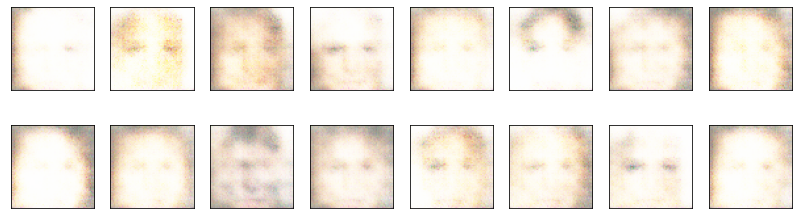

2024-01-29 18:18:27 | Epoch [2/30] | Batch 0/509 | d_loss: 1.3421 | g_loss: 6.5006
2024-01-29 18:18:33 | Epoch [2/30] | Batch 50/509 | d_loss: 0.4683 | g_loss: 4.0183
2024-01-29 18:18:39 | Epoch [2/30] | Batch 100/509 | d_loss: 0.4162 | g_loss: 5.6645
2024-01-29 18:18:46 | Epoch [2/30] | Batch 150/509 | d_loss: 0.4755 | g_loss: 3.8209
2024-01-29 18:18:52 | Epoch [2/30] | Batch 200/509 | d_loss: 0.3925 | g_loss: 3.9529
2024-01-29 18:18:59 | Epoch [2/30] | Batch 250/509 | d_loss: 0.6354 | g_loss: 2.7737
2024-01-29 18:19:05 | Epoch [2/30] | Batch 300/509 | d_loss: 0.4016 | g_loss: 3.7264
2024-01-29 18:19:11 | Epoch [2/30] | Batch 350/509 | d_loss: 0.4314 | g_loss: 4.1729
2024-01-29 18:19:18 | Epoch [2/30] | Batch 400/509 | d_loss: 0.4263 | g_loss: 3.9896
2024-01-29 18:19:24 | Epoch [2/30] | Batch 450/509 | d_loss: 0.4417 | g_loss: 4.9441
2024-01-29 18:19:30 | Epoch [2/30] | Batch 500/509 | d_loss: 0.3786 | g_loss: 3.8738


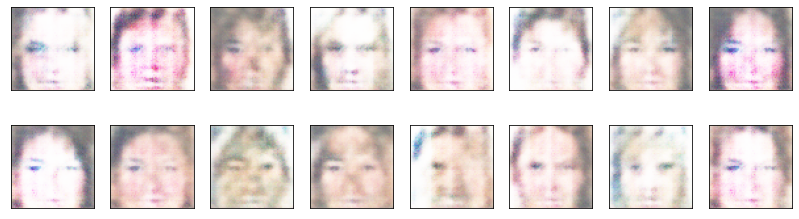

2024-01-29 18:19:36 | Epoch [3/30] | Batch 0/509 | d_loss: 0.4656 | g_loss: 3.8835
2024-01-29 18:19:42 | Epoch [3/30] | Batch 50/509 | d_loss: 1.2594 | g_loss: 8.7664
2024-01-29 18:19:48 | Epoch [3/30] | Batch 100/509 | d_loss: 0.5901 | g_loss: 3.2361
2024-01-29 18:19:54 | Epoch [3/30] | Batch 150/509 | d_loss: 0.4186 | g_loss: 4.5825
2024-01-29 18:20:01 | Epoch [3/30] | Batch 200/509 | d_loss: 0.3998 | g_loss: 3.5542
2024-01-29 18:20:07 | Epoch [3/30] | Batch 250/509 | d_loss: 0.4013 | g_loss: 3.6574
2024-01-29 18:20:14 | Epoch [3/30] | Batch 300/509 | d_loss: 0.4506 | g_loss: 5.2713
2024-01-29 18:20:20 | Epoch [3/30] | Batch 350/509 | d_loss: 0.6167 | g_loss: 2.6650
2024-01-29 18:20:26 | Epoch [3/30] | Batch 400/509 | d_loss: 0.7706 | g_loss: 2.1288
2024-01-29 18:20:32 | Epoch [3/30] | Batch 450/509 | d_loss: 0.4618 | g_loss: 4.7673
2024-01-29 18:20:39 | Epoch [3/30] | Batch 500/509 | d_loss: 0.6313 | g_loss: 2.7434


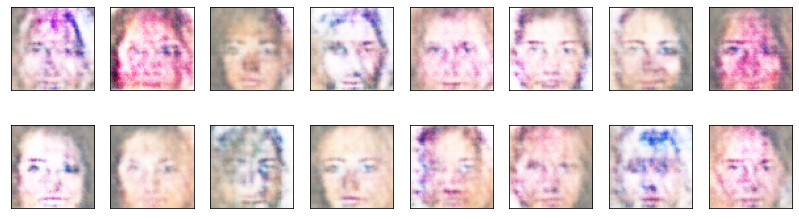

2024-01-29 18:20:44 | Epoch [4/30] | Batch 0/509 | d_loss: 0.4725 | g_loss: 3.8659
2024-01-29 18:20:50 | Epoch [4/30] | Batch 50/509 | d_loss: 0.3906 | g_loss: 3.4044
2024-01-29 18:20:56 | Epoch [4/30] | Batch 100/509 | d_loss: 0.7754 | g_loss: 1.8884
2024-01-29 18:21:02 | Epoch [4/30] | Batch 150/509 | d_loss: 0.4943 | g_loss: 2.5427
2024-01-29 18:21:09 | Epoch [4/30] | Batch 200/509 | d_loss: 0.4296 | g_loss: 4.3354
2024-01-29 18:21:15 | Epoch [4/30] | Batch 250/509 | d_loss: 0.4100 | g_loss: 4.3285
2024-01-29 18:21:21 | Epoch [4/30] | Batch 300/509 | d_loss: 0.3708 | g_loss: 4.3484
2024-01-29 18:21:28 | Epoch [4/30] | Batch 350/509 | d_loss: 0.4839 | g_loss: 3.1955
2024-01-29 18:21:34 | Epoch [4/30] | Batch 400/509 | d_loss: 0.4576 | g_loss: 4.2673
2024-01-29 18:21:40 | Epoch [4/30] | Batch 450/509 | d_loss: 0.5357 | g_loss: 3.5968
2024-01-29 18:21:47 | Epoch [4/30] | Batch 500/509 | d_loss: 0.5467 | g_loss: 2.8936


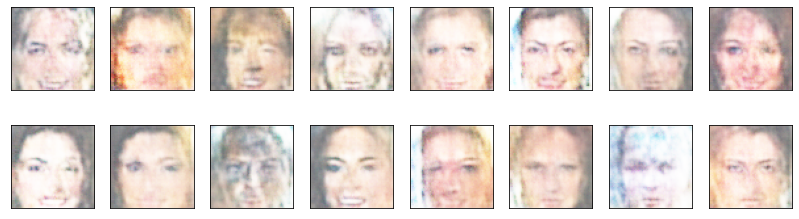

2024-01-29 18:21:51 | Epoch [5/30] | Batch 0/509 | d_loss: 0.4442 | g_loss: 3.3688
2024-01-29 18:21:57 | Epoch [5/30] | Batch 50/509 | d_loss: 0.3677 | g_loss: 4.0064
2024-01-29 18:22:04 | Epoch [5/30] | Batch 100/509 | d_loss: 0.5162 | g_loss: 3.0813
2024-01-29 18:22:10 | Epoch [5/30] | Batch 150/509 | d_loss: 0.4034 | g_loss: 3.5685
2024-01-29 18:22:16 | Epoch [5/30] | Batch 200/509 | d_loss: 0.3727 | g_loss: 4.1935
2024-01-29 18:22:22 | Epoch [5/30] | Batch 250/509 | d_loss: 0.4703 | g_loss: 3.1862
2024-01-29 18:22:29 | Epoch [5/30] | Batch 300/509 | d_loss: 0.4952 | g_loss: 2.7514
2024-01-29 18:22:35 | Epoch [5/30] | Batch 350/509 | d_loss: 0.5576 | g_loss: 5.0265
2024-01-29 18:22:41 | Epoch [5/30] | Batch 400/509 | d_loss: 0.3768 | g_loss: 3.9156
2024-01-29 18:22:48 | Epoch [5/30] | Batch 450/509 | d_loss: 0.8093 | g_loss: 2.1055
2024-01-29 18:22:54 | Epoch [5/30] | Batch 500/509 | d_loss: 0.4965 | g_loss: 3.2945


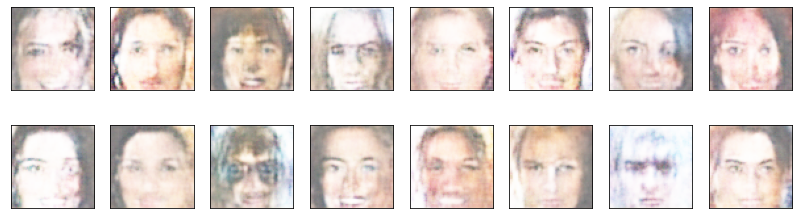

2024-01-29 18:22:59 | Epoch [6/30] | Batch 0/509 | d_loss: 0.3841 | g_loss: 4.0629
2024-01-29 18:23:05 | Epoch [6/30] | Batch 50/509 | d_loss: 0.5215 | g_loss: 4.5095
2024-01-29 18:23:11 | Epoch [6/30] | Batch 100/509 | d_loss: 0.5799 | g_loss: 2.8071
2024-01-29 18:23:18 | Epoch [6/30] | Batch 150/509 | d_loss: 1.4992 | g_loss: 1.5038
2024-01-29 18:23:24 | Epoch [6/30] | Batch 200/509 | d_loss: 0.4194 | g_loss: 4.6157
2024-01-29 18:23:30 | Epoch [6/30] | Batch 250/509 | d_loss: 0.3859 | g_loss: 3.8621
2024-01-29 18:23:36 | Epoch [6/30] | Batch 300/509 | d_loss: 0.4843 | g_loss: 3.1480
2024-01-29 18:23:43 | Epoch [6/30] | Batch 350/509 | d_loss: 0.3888 | g_loss: 3.6206
2024-01-29 18:23:49 | Epoch [6/30] | Batch 400/509 | d_loss: 0.6770 | g_loss: 4.3065
2024-01-29 18:23:55 | Epoch [6/30] | Batch 450/509 | d_loss: 0.6563 | g_loss: 2.1027
2024-01-29 18:24:02 | Epoch [6/30] | Batch 500/509 | d_loss: 0.4019 | g_loss: 3.6065


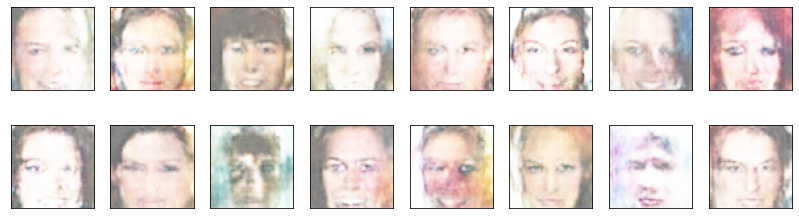

2024-01-29 18:24:06 | Epoch [7/30] | Batch 0/509 | d_loss: 0.3919 | g_loss: 4.5328
2024-01-29 18:24:12 | Epoch [7/30] | Batch 50/509 | d_loss: 0.5676 | g_loss: 2.4030
2024-01-29 18:24:19 | Epoch [7/30] | Batch 100/509 | d_loss: 0.3711 | g_loss: 3.0833
2024-01-29 18:24:25 | Epoch [7/30] | Batch 150/509 | d_loss: 0.5407 | g_loss: 2.5963
2024-01-29 18:24:31 | Epoch [7/30] | Batch 200/509 | d_loss: 0.4838 | g_loss: 4.9313
2024-01-29 18:24:38 | Epoch [7/30] | Batch 250/509 | d_loss: 0.4447 | g_loss: 2.7774
2024-01-29 18:24:44 | Epoch [7/30] | Batch 300/509 | d_loss: 0.5080 | g_loss: 2.8832
2024-01-29 18:24:51 | Epoch [7/30] | Batch 350/509 | d_loss: 0.4373 | g_loss: 3.4459
2024-01-29 18:24:57 | Epoch [7/30] | Batch 400/509 | d_loss: 0.4068 | g_loss: 3.3672
2024-01-29 18:25:03 | Epoch [7/30] | Batch 450/509 | d_loss: 0.5362 | g_loss: 5.8230
2024-01-29 18:25:09 | Epoch [7/30] | Batch 500/509 | d_loss: 0.4076 | g_loss: 4.2211


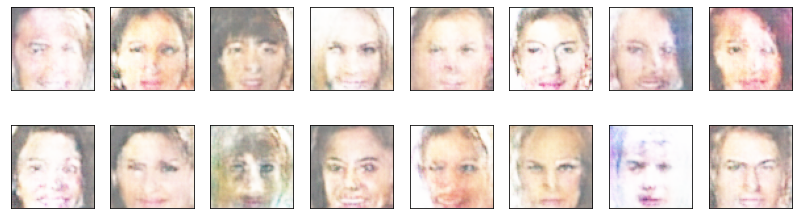

2024-01-29 18:25:16 | Epoch [8/30] | Batch 0/509 | d_loss: 0.4488 | g_loss: 4.0374
2024-01-29 18:25:22 | Epoch [8/30] | Batch 50/509 | d_loss: 0.8810 | g_loss: 1.4550
2024-01-29 18:25:28 | Epoch [8/30] | Batch 100/509 | d_loss: 0.4096 | g_loss: 3.5243
2024-01-29 18:25:35 | Epoch [8/30] | Batch 150/509 | d_loss: 0.6645 | g_loss: 1.9690
2024-01-29 18:25:41 | Epoch [8/30] | Batch 200/509 | d_loss: 0.4354 | g_loss: 3.3760
2024-01-29 18:25:47 | Epoch [8/30] | Batch 250/509 | d_loss: 0.4708 | g_loss: 2.6530
2024-01-29 18:25:54 | Epoch [8/30] | Batch 300/509 | d_loss: 0.4349 | g_loss: 3.6474
2024-01-29 18:26:00 | Epoch [8/30] | Batch 350/509 | d_loss: 0.3803 | g_loss: 4.5425
2024-01-29 18:26:07 | Epoch [8/30] | Batch 400/509 | d_loss: 0.4391 | g_loss: 3.1730
2024-01-29 18:26:13 | Epoch [8/30] | Batch 450/509 | d_loss: 0.5143 | g_loss: 2.3753
2024-01-29 18:26:19 | Epoch [8/30] | Batch 500/509 | d_loss: 0.4893 | g_loss: 3.5256


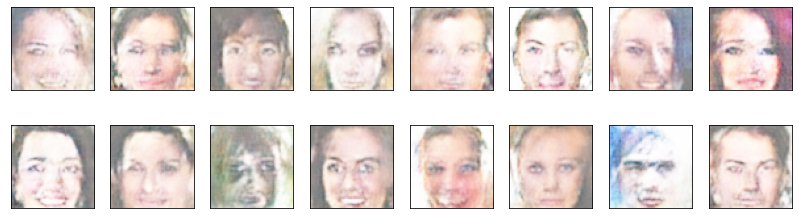

2024-01-29 18:26:24 | Epoch [9/30] | Batch 0/509 | d_loss: 0.5269 | g_loss: 4.6049
2024-01-29 18:26:30 | Epoch [9/30] | Batch 50/509 | d_loss: 0.4728 | g_loss: 2.9911
2024-01-29 18:26:36 | Epoch [9/30] | Batch 100/509 | d_loss: 0.3938 | g_loss: 3.4734
2024-01-29 18:26:43 | Epoch [9/30] | Batch 150/509 | d_loss: 0.5669 | g_loss: 4.3142
2024-01-29 18:26:49 | Epoch [9/30] | Batch 200/509 | d_loss: 0.4316 | g_loss: 3.9150
2024-01-29 18:26:55 | Epoch [9/30] | Batch 250/509 | d_loss: 0.4899 | g_loss: 3.6520
2024-01-29 18:27:02 | Epoch [9/30] | Batch 300/509 | d_loss: 0.3685 | g_loss: 4.3582
2024-01-29 18:27:08 | Epoch [9/30] | Batch 350/509 | d_loss: 1.0565 | g_loss: 6.7005
2024-01-29 18:27:14 | Epoch [9/30] | Batch 400/509 | d_loss: 0.4782 | g_loss: 3.3532
2024-01-29 18:27:21 | Epoch [9/30] | Batch 450/509 | d_loss: 0.3822 | g_loss: 4.0557
2024-01-29 18:27:27 | Epoch [9/30] | Batch 500/509 | d_loss: 0.4941 | g_loss: 4.6666


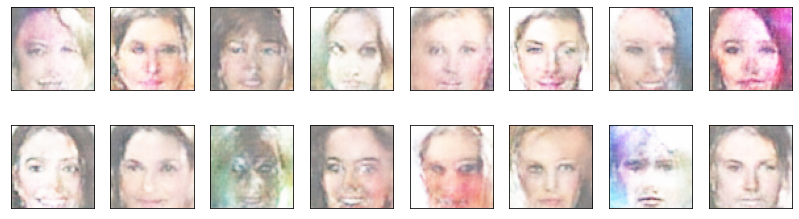

2024-01-29 18:27:32 | Epoch [10/30] | Batch 0/509 | d_loss: 0.4635 | g_loss: 4.6468
2024-01-29 18:27:39 | Epoch [10/30] | Batch 50/509 | d_loss: 0.5736 | g_loss: 2.9398
2024-01-29 18:27:45 | Epoch [10/30] | Batch 100/509 | d_loss: 0.4437 | g_loss: 4.0673
2024-01-29 18:27:51 | Epoch [10/30] | Batch 150/509 | d_loss: 0.5877 | g_loss: 2.7802
2024-01-29 18:27:58 | Epoch [10/30] | Batch 200/509 | d_loss: 0.5108 | g_loss: 2.9912
2024-01-29 18:28:04 | Epoch [10/30] | Batch 250/509 | d_loss: 0.4076 | g_loss: 3.0453
2024-01-29 18:28:10 | Epoch [10/30] | Batch 300/509 | d_loss: 0.4270 | g_loss: 3.9174
2024-01-29 18:28:16 | Epoch [10/30] | Batch 350/509 | d_loss: 0.4018 | g_loss: 4.0883
2024-01-29 18:28:23 | Epoch [10/30] | Batch 400/509 | d_loss: 0.6570 | g_loss: 2.6466
2024-01-29 18:28:29 | Epoch [10/30] | Batch 450/509 | d_loss: 0.3753 | g_loss: 4.1176
2024-01-29 18:28:36 | Epoch [10/30] | Batch 500/509 | d_loss: 0.5191 | g_loss: 3.8090


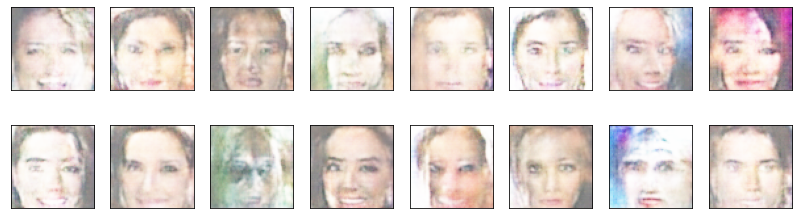

2024-01-29 18:28:40 | Epoch [11/30] | Batch 0/509 | d_loss: 0.4304 | g_loss: 3.6497
2024-01-29 18:28:47 | Epoch [11/30] | Batch 50/509 | d_loss: 0.3782 | g_loss: 3.7969
2024-01-29 18:28:53 | Epoch [11/30] | Batch 100/509 | d_loss: 0.5006 | g_loss: 3.0848
2024-01-29 18:28:59 | Epoch [11/30] | Batch 150/509 | d_loss: 0.4001 | g_loss: 3.7275
2024-01-29 18:29:06 | Epoch [11/30] | Batch 200/509 | d_loss: 0.4141 | g_loss: 3.6553
2024-01-29 18:29:12 | Epoch [11/30] | Batch 250/509 | d_loss: 1.2602 | g_loss: 5.3979
2024-01-29 18:29:18 | Epoch [11/30] | Batch 300/509 | d_loss: 0.4554 | g_loss: 3.9141
2024-01-29 18:29:25 | Epoch [11/30] | Batch 350/509 | d_loss: 0.4330 | g_loss: 3.6117
2024-01-29 18:29:31 | Epoch [11/30] | Batch 400/509 | d_loss: 0.4165 | g_loss: 4.0250
2024-01-29 18:29:37 | Epoch [11/30] | Batch 450/509 | d_loss: 0.3993 | g_loss: 3.9008
2024-01-29 18:29:44 | Epoch [11/30] | Batch 500/509 | d_loss: 0.4890 | g_loss: 3.6942


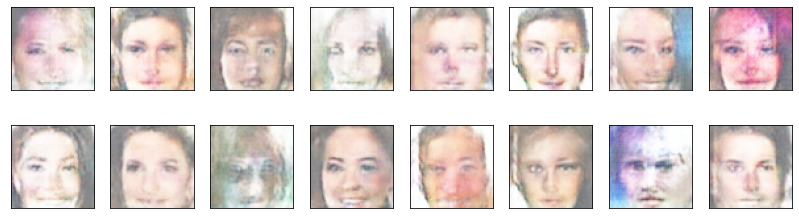

2024-01-29 18:29:49 | Epoch [12/30] | Batch 0/509 | d_loss: 0.4429 | g_loss: 2.8619
2024-01-29 18:29:55 | Epoch [12/30] | Batch 50/509 | d_loss: 0.3853 | g_loss: 4.2421
2024-01-29 18:30:02 | Epoch [12/30] | Batch 100/509 | d_loss: 0.3724 | g_loss: 4.7625
2024-01-29 18:30:08 | Epoch [12/30] | Batch 150/509 | d_loss: 0.3997 | g_loss: 3.7848
2024-01-29 18:30:14 | Epoch [12/30] | Batch 200/509 | d_loss: 0.3799 | g_loss: 4.5544
2024-01-29 18:30:21 | Epoch [12/30] | Batch 250/509 | d_loss: 0.6116 | g_loss: 5.8719
2024-01-29 18:30:27 | Epoch [12/30] | Batch 300/509 | d_loss: 0.4082 | g_loss: 3.7428
2024-01-29 18:30:33 | Epoch [12/30] | Batch 350/509 | d_loss: 0.3929 | g_loss: 4.3865
2024-01-29 18:30:40 | Epoch [12/30] | Batch 400/509 | d_loss: 0.4166 | g_loss: 3.4335
2024-01-29 18:30:46 | Epoch [12/30] | Batch 450/509 | d_loss: 0.4352 | g_loss: 4.6886
2024-01-29 18:30:52 | Epoch [12/30] | Batch 500/509 | d_loss: 0.3810 | g_loss: 5.0328


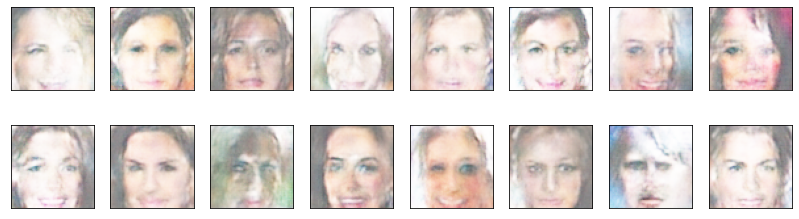

2024-01-29 18:30:58 | Epoch [13/30] | Batch 0/509 | d_loss: 0.7591 | g_loss: 5.3497
2024-01-29 18:31:04 | Epoch [13/30] | Batch 50/509 | d_loss: 0.3781 | g_loss: 4.3544
2024-01-29 18:31:11 | Epoch [13/30] | Batch 100/509 | d_loss: 0.4743 | g_loss: 3.0487
2024-01-29 18:31:17 | Epoch [13/30] | Batch 150/509 | d_loss: 1.1306 | g_loss: 7.9764
2024-01-29 18:31:23 | Epoch [13/30] | Batch 200/509 | d_loss: 0.4274 | g_loss: 3.3005
2024-01-29 18:31:30 | Epoch [13/30] | Batch 250/509 | d_loss: 0.4252 | g_loss: 4.2307
2024-01-29 18:31:36 | Epoch [13/30] | Batch 300/509 | d_loss: 0.4000 | g_loss: 3.9048
2024-01-29 18:31:43 | Epoch [13/30] | Batch 350/509 | d_loss: 0.3747 | g_loss: 4.1086
2024-01-29 18:31:49 | Epoch [13/30] | Batch 400/509 | d_loss: 0.3987 | g_loss: 4.2289
2024-01-29 18:31:55 | Epoch [13/30] | Batch 450/509 | d_loss: 0.5603 | g_loss: 4.5420
2024-01-29 18:32:02 | Epoch [13/30] | Batch 500/509 | d_loss: 0.4110 | g_loss: 4.8080


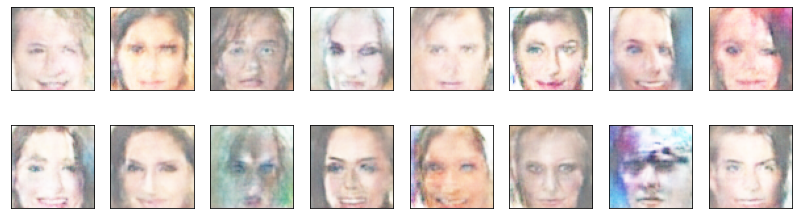

2024-01-29 18:32:06 | Epoch [14/30] | Batch 0/509 | d_loss: 0.3880 | g_loss: 4.0862
2024-01-29 18:32:13 | Epoch [14/30] | Batch 50/509 | d_loss: 0.4519 | g_loss: 3.4512
2024-01-29 18:32:19 | Epoch [14/30] | Batch 100/509 | d_loss: 0.3879 | g_loss: 4.1460
2024-01-29 18:32:25 | Epoch [14/30] | Batch 150/509 | d_loss: 0.4054 | g_loss: 4.3904
2024-01-29 18:32:32 | Epoch [14/30] | Batch 200/509 | d_loss: 0.4118 | g_loss: 3.3917
2024-01-29 18:32:38 | Epoch [14/30] | Batch 250/509 | d_loss: 0.4958 | g_loss: 5.3682
2024-01-29 18:32:44 | Epoch [14/30] | Batch 300/509 | d_loss: 0.4019 | g_loss: 3.5213
2024-01-29 18:32:51 | Epoch [14/30] | Batch 350/509 | d_loss: 0.4574 | g_loss: 4.0153
2024-01-29 18:32:57 | Epoch [14/30] | Batch 400/509 | d_loss: 0.4878 | g_loss: 3.4605
2024-01-29 18:33:03 | Epoch [14/30] | Batch 450/509 | d_loss: 0.7239 | g_loss: 5.5109
2024-01-29 18:33:10 | Epoch [14/30] | Batch 500/509 | d_loss: 0.4961 | g_loss: 3.9401


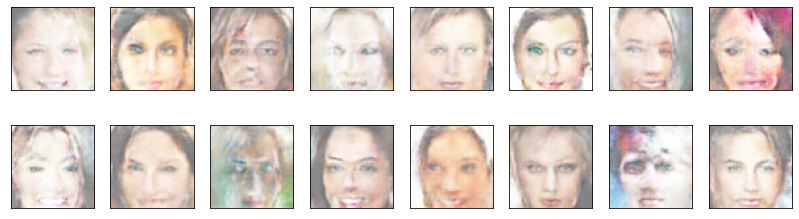

2024-01-29 18:33:15 | Epoch [15/30] | Batch 0/509 | d_loss: 0.4574 | g_loss: 5.3584
2024-01-29 18:33:21 | Epoch [15/30] | Batch 50/509 | d_loss: 0.4084 | g_loss: 3.0207
2024-01-29 18:33:28 | Epoch [15/30] | Batch 100/509 | d_loss: 0.3809 | g_loss: 4.8100
2024-01-29 18:33:34 | Epoch [15/30] | Batch 150/509 | d_loss: 0.3771 | g_loss: 3.7042
2024-01-29 18:33:41 | Epoch [15/30] | Batch 200/509 | d_loss: 0.3779 | g_loss: 4.0639
2024-01-29 18:33:47 | Epoch [15/30] | Batch 250/509 | d_loss: 0.4550 | g_loss: 4.0677
2024-01-29 18:33:53 | Epoch [15/30] | Batch 300/509 | d_loss: 0.3855 | g_loss: 4.7934
2024-01-29 18:34:00 | Epoch [15/30] | Batch 350/509 | d_loss: 0.4629 | g_loss: 5.4117
2024-01-29 18:34:06 | Epoch [15/30] | Batch 400/509 | d_loss: 0.3841 | g_loss: 4.8252
2024-01-29 18:34:12 | Epoch [15/30] | Batch 450/509 | d_loss: 0.3834 | g_loss: 4.2871
2024-01-29 18:34:19 | Epoch [15/30] | Batch 500/509 | d_loss: 0.5653 | g_loss: 2.9111


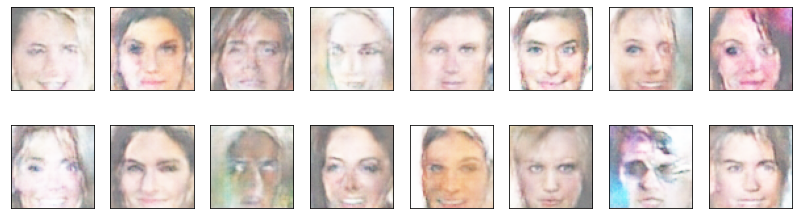

2024-01-29 18:34:24 | Epoch [16/30] | Batch 0/509 | d_loss: 0.3859 | g_loss: 5.0887
2024-01-29 18:34:30 | Epoch [16/30] | Batch 50/509 | d_loss: 0.3798 | g_loss: 5.3078
2024-01-29 18:34:37 | Epoch [16/30] | Batch 100/509 | d_loss: 0.4986 | g_loss: 4.3466
2024-01-29 18:34:43 | Epoch [16/30] | Batch 150/509 | d_loss: 0.3976 | g_loss: 4.3456
2024-01-29 18:34:49 | Epoch [16/30] | Batch 200/509 | d_loss: 0.4481 | g_loss: 4.3968
2024-01-29 18:34:56 | Epoch [16/30] | Batch 250/509 | d_loss: 0.4136 | g_loss: 4.2627
2024-01-29 18:35:02 | Epoch [16/30] | Batch 300/509 | d_loss: 0.3925 | g_loss: 4.8179
2024-01-29 18:35:08 | Epoch [16/30] | Batch 350/509 | d_loss: 0.3887 | g_loss: 4.6349
2024-01-29 18:35:15 | Epoch [16/30] | Batch 400/509 | d_loss: 0.6563 | g_loss: 2.1257
2024-01-29 18:35:21 | Epoch [16/30] | Batch 450/509 | d_loss: 0.3832 | g_loss: 4.2224
2024-01-29 18:35:27 | Epoch [16/30] | Batch 500/509 | d_loss: 0.3755 | g_loss: 5.3928


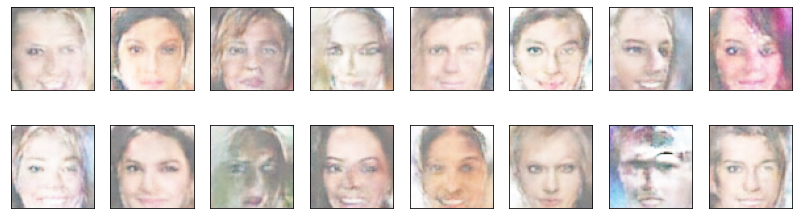

2024-01-29 18:35:34 | Epoch [17/30] | Batch 0/509 | d_loss: 0.3947 | g_loss: 4.1170
2024-01-29 18:35:40 | Epoch [17/30] | Batch 50/509 | d_loss: 0.4995 | g_loss: 6.1876
2024-01-29 18:35:46 | Epoch [17/30] | Batch 100/509 | d_loss: 0.3740 | g_loss: 5.2548
2024-01-29 18:35:52 | Epoch [17/30] | Batch 150/509 | d_loss: 0.5185 | g_loss: 6.1067
2024-01-29 18:35:59 | Epoch [17/30] | Batch 200/509 | d_loss: 0.3636 | g_loss: 4.3980
2024-01-29 18:36:05 | Epoch [17/30] | Batch 250/509 | d_loss: 0.4312 | g_loss: 4.2295
2024-01-29 18:36:12 | Epoch [17/30] | Batch 300/509 | d_loss: 0.4179 | g_loss: 4.6181
2024-01-29 18:36:18 | Epoch [17/30] | Batch 350/509 | d_loss: 0.4207 | g_loss: 3.9927
2024-01-29 18:36:24 | Epoch [17/30] | Batch 400/509 | d_loss: 0.5494 | g_loss: 2.8566
2024-01-29 18:36:31 | Epoch [17/30] | Batch 450/509 | d_loss: 0.3899 | g_loss: 3.7404
2024-01-29 18:36:37 | Epoch [17/30] | Batch 500/509 | d_loss: 0.7735 | g_loss: 1.9746


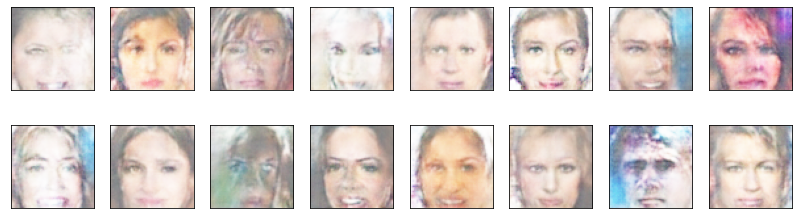

2024-01-29 18:36:43 | Epoch [18/30] | Batch 0/509 | d_loss: 0.4590 | g_loss: 3.2924
2024-01-29 18:36:49 | Epoch [18/30] | Batch 50/509 | d_loss: 0.3958 | g_loss: 4.9854
2024-01-29 18:36:56 | Epoch [18/30] | Batch 100/509 | d_loss: 0.3884 | g_loss: 4.1739
2024-01-29 18:37:02 | Epoch [18/30] | Batch 150/509 | d_loss: 0.3779 | g_loss: 4.9852
2024-01-29 18:37:08 | Epoch [18/30] | Batch 200/509 | d_loss: 0.4898 | g_loss: 3.5225
2024-01-29 18:37:15 | Epoch [18/30] | Batch 250/509 | d_loss: 0.4135 | g_loss: 4.6010
2024-01-29 18:37:21 | Epoch [18/30] | Batch 300/509 | d_loss: 0.3680 | g_loss: 4.9533
2024-01-29 18:37:27 | Epoch [18/30] | Batch 350/509 | d_loss: 0.5940 | g_loss: 2.2058
2024-01-29 18:37:34 | Epoch [18/30] | Batch 400/509 | d_loss: 0.3778 | g_loss: 4.3506
2024-01-29 18:37:40 | Epoch [18/30] | Batch 450/509 | d_loss: 0.4682 | g_loss: 3.3575
2024-01-29 18:37:46 | Epoch [18/30] | Batch 500/509 | d_loss: 0.4070 | g_loss: 5.5551


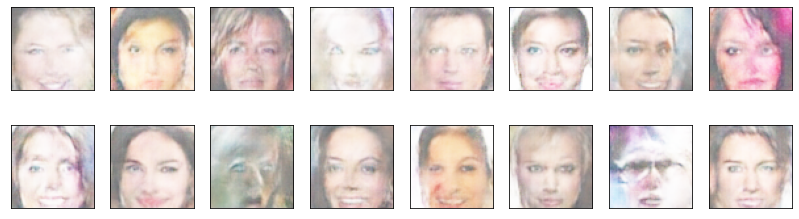

2024-01-29 18:37:52 | Epoch [19/30] | Batch 0/509 | d_loss: 1.2765 | g_loss: 2.3689
2024-01-29 18:37:58 | Epoch [19/30] | Batch 50/509 | d_loss: 0.4744 | g_loss: 3.5451
2024-01-29 18:38:04 | Epoch [19/30] | Batch 100/509 | d_loss: 0.4136 | g_loss: 4.2143
2024-01-29 18:38:11 | Epoch [19/30] | Batch 150/509 | d_loss: 0.3663 | g_loss: 4.6394
2024-01-29 18:38:17 | Epoch [19/30] | Batch 200/509 | d_loss: 0.3844 | g_loss: 3.4629
2024-01-29 18:38:23 | Epoch [19/30] | Batch 250/509 | d_loss: 0.3950 | g_loss: 3.9957
2024-01-29 18:38:30 | Epoch [19/30] | Batch 300/509 | d_loss: 0.3944 | g_loss: 3.6292
2024-01-29 18:38:36 | Epoch [19/30] | Batch 350/509 | d_loss: 0.3617 | g_loss: 4.8108
2024-01-29 18:38:43 | Epoch [19/30] | Batch 400/509 | d_loss: 0.3938 | g_loss: 3.9936
2024-01-29 18:38:49 | Epoch [19/30] | Batch 450/509 | d_loss: 0.3844 | g_loss: 3.9121
2024-01-29 18:38:55 | Epoch [19/30] | Batch 500/509 | d_loss: 0.4159 | g_loss: 4.9807


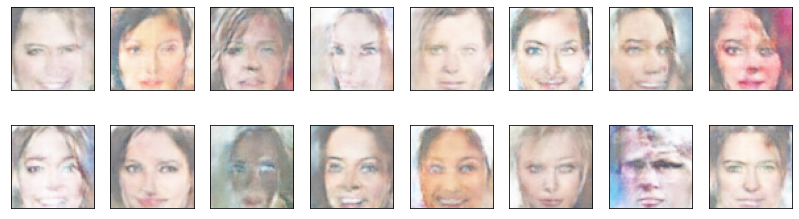

2024-01-29 18:38:59 | Epoch [20/30] | Batch 0/509 | d_loss: 0.5363 | g_loss: 3.1872
2024-01-29 18:39:06 | Epoch [20/30] | Batch 50/509 | d_loss: 0.3593 | g_loss: 4.7838
2024-01-29 18:39:12 | Epoch [20/30] | Batch 100/509 | d_loss: 0.3906 | g_loss: 4.0132
2024-01-29 18:39:18 | Epoch [20/30] | Batch 150/509 | d_loss: 0.4387 | g_loss: 5.3648
2024-01-29 18:39:24 | Epoch [20/30] | Batch 200/509 | d_loss: 0.5219 | g_loss: 5.0594
2024-01-29 18:39:31 | Epoch [20/30] | Batch 250/509 | d_loss: 0.4887 | g_loss: 5.7368
2024-01-29 18:39:37 | Epoch [20/30] | Batch 300/509 | d_loss: 0.3945 | g_loss: 4.1542
2024-01-29 18:39:43 | Epoch [20/30] | Batch 350/509 | d_loss: 0.5020 | g_loss: 2.5545
2024-01-29 18:39:50 | Epoch [20/30] | Batch 400/509 | d_loss: 0.4264 | g_loss: 4.4419
2024-01-29 18:39:56 | Epoch [20/30] | Batch 450/509 | d_loss: 0.3935 | g_loss: 4.2855
2024-01-29 18:40:02 | Epoch [20/30] | Batch 500/509 | d_loss: 0.4014 | g_loss: 5.0696


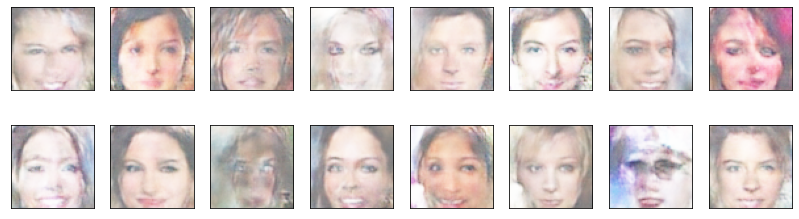

2024-01-29 18:40:07 | Epoch [21/30] | Batch 0/509 | d_loss: 0.3721 | g_loss: 4.6558
2024-01-29 18:40:14 | Epoch [21/30] | Batch 50/509 | d_loss: 0.5223 | g_loss: 3.3858
2024-01-29 18:40:20 | Epoch [21/30] | Batch 100/509 | d_loss: 0.4147 | g_loss: 4.9478
2024-01-29 18:40:27 | Epoch [21/30] | Batch 150/509 | d_loss: 0.3880 | g_loss: 4.0793
2024-01-29 18:40:33 | Epoch [21/30] | Batch 200/509 | d_loss: 0.4421 | g_loss: 5.0775
2024-01-29 18:40:39 | Epoch [21/30] | Batch 250/509 | d_loss: 0.4723 | g_loss: 3.7235
2024-01-29 18:40:46 | Epoch [21/30] | Batch 300/509 | d_loss: 0.3890 | g_loss: 3.9597
2024-01-29 18:40:52 | Epoch [21/30] | Batch 350/509 | d_loss: 0.6148 | g_loss: 6.9321
2024-01-29 18:40:58 | Epoch [21/30] | Batch 400/509 | d_loss: 0.4522 | g_loss: 3.5510
2024-01-29 18:41:05 | Epoch [21/30] | Batch 450/509 | d_loss: 0.4025 | g_loss: 4.3658
2024-01-29 18:41:11 | Epoch [21/30] | Batch 500/509 | d_loss: 0.3957 | g_loss: 3.9152


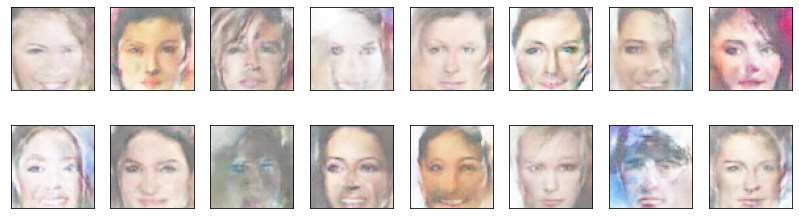

2024-01-29 18:41:16 | Epoch [22/30] | Batch 0/509 | d_loss: 0.3733 | g_loss: 5.5892
2024-01-29 18:41:22 | Epoch [22/30] | Batch 50/509 | d_loss: 0.4246 | g_loss: 3.2907
2024-01-29 18:41:28 | Epoch [22/30] | Batch 100/509 | d_loss: 0.5544 | g_loss: 2.5049
2024-01-29 18:41:35 | Epoch [22/30] | Batch 150/509 | d_loss: 0.4064 | g_loss: 3.7949
2024-01-29 18:41:41 | Epoch [22/30] | Batch 200/509 | d_loss: 0.3649 | g_loss: 4.8426
2024-01-29 18:41:47 | Epoch [22/30] | Batch 250/509 | d_loss: 0.3743 | g_loss: 4.5862
2024-01-29 18:41:54 | Epoch [22/30] | Batch 300/509 | d_loss: 0.3749 | g_loss: 4.3669
2024-01-29 18:42:00 | Epoch [22/30] | Batch 350/509 | d_loss: 0.3803 | g_loss: 4.8510
2024-01-29 18:42:06 | Epoch [22/30] | Batch 400/509 | d_loss: 0.4285 | g_loss: 3.8180
2024-01-29 18:42:13 | Epoch [22/30] | Batch 450/509 | d_loss: 0.5169 | g_loss: 2.7680
2024-01-29 18:42:19 | Epoch [22/30] | Batch 500/509 | d_loss: 0.4714 | g_loss: 3.0748


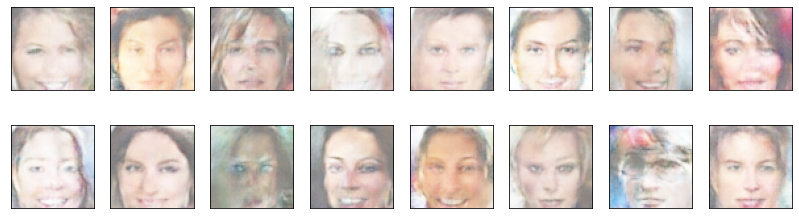

2024-01-29 18:42:24 | Epoch [23/30] | Batch 0/509 | d_loss: 0.4208 | g_loss: 3.7757
2024-01-29 18:42:31 | Epoch [23/30] | Batch 50/509 | d_loss: 0.5497 | g_loss: 2.9478
2024-01-29 18:42:37 | Epoch [23/30] | Batch 100/509 | d_loss: 0.3802 | g_loss: 4.0843
2024-01-29 18:42:43 | Epoch [23/30] | Batch 150/509 | d_loss: 0.3812 | g_loss: 5.5486
2024-01-29 18:42:50 | Epoch [23/30] | Batch 200/509 | d_loss: 0.3996 | g_loss: 4.6163
2024-01-29 18:42:56 | Epoch [23/30] | Batch 250/509 | d_loss: 0.4263 | g_loss: 2.9119
2024-01-29 18:43:03 | Epoch [23/30] | Batch 300/509 | d_loss: 0.4147 | g_loss: 4.1742
2024-01-29 18:43:09 | Epoch [23/30] | Batch 350/509 | d_loss: 0.5768 | g_loss: 2.9923
2024-01-29 18:43:15 | Epoch [23/30] | Batch 400/509 | d_loss: 0.4763 | g_loss: 3.3444
2024-01-29 18:43:22 | Epoch [23/30] | Batch 450/509 | d_loss: 0.4154 | g_loss: 3.9829
2024-01-29 18:43:28 | Epoch [23/30] | Batch 500/509 | d_loss: 0.4051 | g_loss: 3.9324


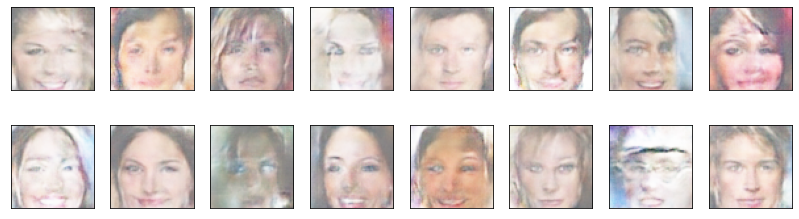

2024-01-29 18:43:33 | Epoch [24/30] | Batch 0/509 | d_loss: 0.5113 | g_loss: 5.7054
2024-01-29 18:43:39 | Epoch [24/30] | Batch 50/509 | d_loss: 0.4072 | g_loss: 4.5839
2024-01-29 18:43:46 | Epoch [24/30] | Batch 100/509 | d_loss: 0.3765 | g_loss: 4.7188
2024-01-29 18:43:52 | Epoch [24/30] | Batch 150/509 | d_loss: 0.6418 | g_loss: 6.5884
2024-01-29 18:43:58 | Epoch [24/30] | Batch 200/509 | d_loss: 0.3677 | g_loss: 4.7827
2024-01-29 18:44:05 | Epoch [24/30] | Batch 250/509 | d_loss: 0.4725 | g_loss: 3.2524
2024-01-29 18:44:11 | Epoch [24/30] | Batch 300/509 | d_loss: 0.5305 | g_loss: 3.3286
2024-01-29 18:44:18 | Epoch [24/30] | Batch 350/509 | d_loss: 0.4560 | g_loss: 4.5360
2024-01-29 18:44:24 | Epoch [24/30] | Batch 400/509 | d_loss: 0.4436 | g_loss: 4.1917
2024-01-29 18:44:30 | Epoch [24/30] | Batch 450/509 | d_loss: 0.3830 | g_loss: 5.0282
2024-01-29 18:44:37 | Epoch [24/30] | Batch 500/509 | d_loss: 0.4338 | g_loss: 3.6543


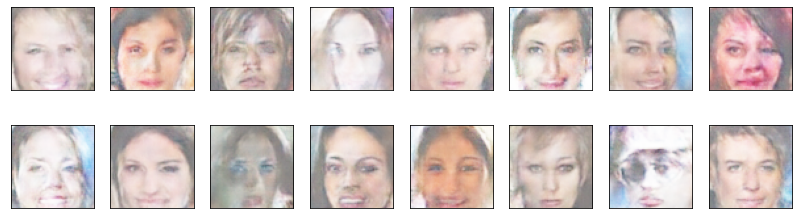

2024-01-29 18:44:42 | Epoch [25/30] | Batch 0/509 | d_loss: 0.3637 | g_loss: 4.6541
2024-01-29 18:44:49 | Epoch [25/30] | Batch 50/509 | d_loss: 0.3823 | g_loss: 5.1175
2024-01-29 18:44:55 | Epoch [25/30] | Batch 100/509 | d_loss: 1.6619 | g_loss: 8.1366
2024-01-29 18:45:02 | Epoch [25/30] | Batch 150/509 | d_loss: 0.4391 | g_loss: 5.5326
2024-01-29 18:45:08 | Epoch [25/30] | Batch 200/509 | d_loss: 0.3945 | g_loss: 3.8779
2024-01-29 18:45:14 | Epoch [25/30] | Batch 250/509 | d_loss: 0.4058 | g_loss: 3.9347
2024-01-29 18:45:21 | Epoch [25/30] | Batch 300/509 | d_loss: 0.4170 | g_loss: 4.1927
2024-01-29 18:45:27 | Epoch [25/30] | Batch 350/509 | d_loss: 0.5444 | g_loss: 5.6231
2024-01-29 18:45:33 | Epoch [25/30] | Batch 400/509 | d_loss: 0.3528 | g_loss: 4.9713
2024-01-29 18:45:40 | Epoch [25/30] | Batch 450/509 | d_loss: 0.3986 | g_loss: 4.1251
2024-01-29 18:45:46 | Epoch [25/30] | Batch 500/509 | d_loss: 0.4667 | g_loss: 5.1119


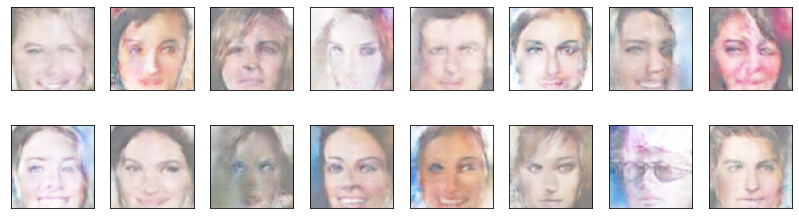

2024-01-29 18:45:52 | Epoch [26/30] | Batch 0/509 | d_loss: 0.4052 | g_loss: 4.2401
2024-01-29 18:45:58 | Epoch [26/30] | Batch 50/509 | d_loss: 0.4536 | g_loss: 6.3802
2024-01-29 18:46:05 | Epoch [26/30] | Batch 100/509 | d_loss: 0.4104 | g_loss: 4.4745
2024-01-29 18:46:11 | Epoch [26/30] | Batch 150/509 | d_loss: 0.4365 | g_loss: 4.0570
2024-01-29 18:46:17 | Epoch [26/30] | Batch 200/509 | d_loss: 0.8413 | g_loss: 1.4634
2024-01-29 18:46:24 | Epoch [26/30] | Batch 250/509 | d_loss: 0.3633 | g_loss: 5.2638
2024-01-29 18:46:30 | Epoch [26/30] | Batch 300/509 | d_loss: 0.5633 | g_loss: 2.9140
2024-01-29 18:46:36 | Epoch [26/30] | Batch 350/509 | d_loss: 0.3783 | g_loss: 4.3879
2024-01-29 18:46:43 | Epoch [26/30] | Batch 400/509 | d_loss: 0.4097 | g_loss: 4.3423
2024-01-29 18:46:49 | Epoch [26/30] | Batch 450/509 | d_loss: 0.4030 | g_loss: 3.5358
2024-01-29 18:46:56 | Epoch [26/30] | Batch 500/509 | d_loss: 0.3841 | g_loss: 4.8978


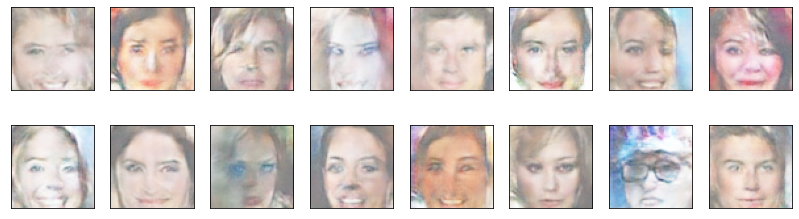

2024-01-29 18:47:01 | Epoch [27/30] | Batch 0/509 | d_loss: 0.5623 | g_loss: 6.4249
2024-01-29 18:47:08 | Epoch [27/30] | Batch 50/509 | d_loss: 0.4339 | g_loss: 4.6529
2024-01-29 18:47:14 | Epoch [27/30] | Batch 100/509 | d_loss: 0.4610 | g_loss: 4.9666
2024-01-29 18:47:21 | Epoch [27/30] | Batch 150/509 | d_loss: 0.4011 | g_loss: 3.8846
2024-01-29 18:47:27 | Epoch [27/30] | Batch 200/509 | d_loss: 0.4683 | g_loss: 3.6532
2024-01-29 18:47:33 | Epoch [27/30] | Batch 250/509 | d_loss: 0.3694 | g_loss: 4.5032
2024-01-29 18:47:39 | Epoch [27/30] | Batch 300/509 | d_loss: 0.3894 | g_loss: 4.1998
2024-01-29 18:47:46 | Epoch [27/30] | Batch 350/509 | d_loss: 0.4991 | g_loss: 3.3528
2024-01-29 18:47:52 | Epoch [27/30] | Batch 400/509 | d_loss: 0.4604 | g_loss: 3.7904
2024-01-29 18:47:59 | Epoch [27/30] | Batch 450/509 | d_loss: 0.6236 | g_loss: 3.2565
2024-01-29 18:48:05 | Epoch [27/30] | Batch 500/509 | d_loss: 0.4027 | g_loss: 4.5092


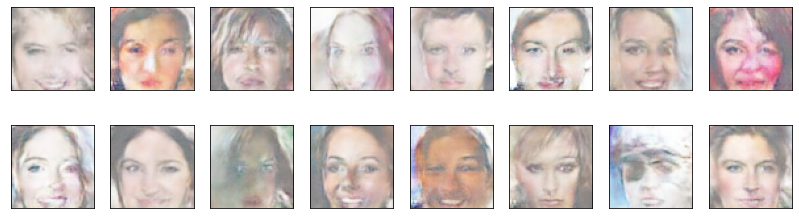

2024-01-29 18:48:11 | Epoch [28/30] | Batch 0/509 | d_loss: 0.4152 | g_loss: 3.3150
2024-01-29 18:48:17 | Epoch [28/30] | Batch 50/509 | d_loss: 0.3604 | g_loss: 5.1907
2024-01-29 18:48:23 | Epoch [28/30] | Batch 100/509 | d_loss: 0.4040 | g_loss: 3.5303
2024-01-29 18:48:29 | Epoch [28/30] | Batch 150/509 | d_loss: 0.8882 | g_loss: 2.2707
2024-01-29 18:48:36 | Epoch [28/30] | Batch 200/509 | d_loss: 0.4140 | g_loss: 4.0822
2024-01-29 18:48:42 | Epoch [28/30] | Batch 250/509 | d_loss: 0.3852 | g_loss: 4.7138
2024-01-29 18:48:48 | Epoch [28/30] | Batch 300/509 | d_loss: 0.3820 | g_loss: 4.8446
2024-01-29 18:48:55 | Epoch [28/30] | Batch 350/509 | d_loss: 0.4108 | g_loss: 3.7423
2024-01-29 18:49:01 | Epoch [28/30] | Batch 400/509 | d_loss: 0.4247 | g_loss: 5.3501
2024-01-29 18:49:08 | Epoch [28/30] | Batch 450/509 | d_loss: 0.3639 | g_loss: 4.6782
2024-01-29 18:49:14 | Epoch [28/30] | Batch 500/509 | d_loss: 0.4296 | g_loss: 4.2549


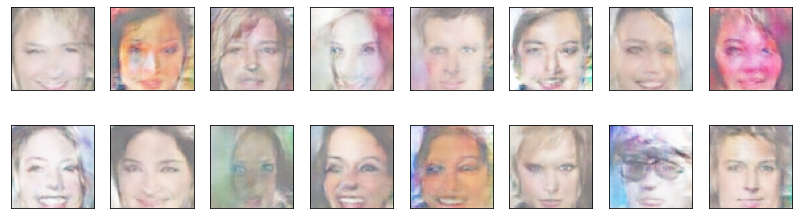

2024-01-29 18:49:19 | Epoch [29/30] | Batch 0/509 | d_loss: 0.3839 | g_loss: 4.7896
2024-01-29 18:49:25 | Epoch [29/30] | Batch 50/509 | d_loss: 0.4224 | g_loss: 5.0071
2024-01-29 18:49:31 | Epoch [29/30] | Batch 100/509 | d_loss: 0.5340 | g_loss: 2.4556
2024-01-29 18:49:37 | Epoch [29/30] | Batch 150/509 | d_loss: 0.3623 | g_loss: 4.3273
2024-01-29 18:49:44 | Epoch [29/30] | Batch 200/509 | d_loss: 0.3796 | g_loss: 5.1538
2024-01-29 18:49:50 | Epoch [29/30] | Batch 250/509 | d_loss: 0.3967 | g_loss: 3.8650
2024-01-29 18:49:57 | Epoch [29/30] | Batch 300/509 | d_loss: 0.5079 | g_loss: 3.7573
2024-01-29 18:50:03 | Epoch [29/30] | Batch 350/509 | d_loss: 0.3981 | g_loss: 5.8117
2024-01-29 18:50:10 | Epoch [29/30] | Batch 400/509 | d_loss: 0.5715 | g_loss: 3.5690
2024-01-29 18:50:16 | Epoch [29/30] | Batch 450/509 | d_loss: 0.3603 | g_loss: 4.4673
2024-01-29 18:50:22 | Epoch [29/30] | Batch 500/509 | d_loss: 0.3693 | g_loss: 3.9470


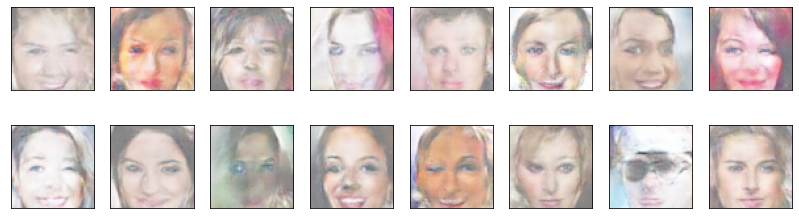

2024-01-29 18:50:28 | Epoch [30/30] | Batch 0/509 | d_loss: 0.4057 | g_loss: 4.1838
2024-01-29 18:50:34 | Epoch [30/30] | Batch 50/509 | d_loss: 0.3701 | g_loss: 6.3344
2024-01-29 18:50:40 | Epoch [30/30] | Batch 100/509 | d_loss: 0.3625 | g_loss: 3.7732
2024-01-29 18:50:47 | Epoch [30/30] | Batch 150/509 | d_loss: 0.4016 | g_loss: 4.0562
2024-01-29 18:50:53 | Epoch [30/30] | Batch 200/509 | d_loss: 0.3719 | g_loss: 4.5705
2024-01-29 18:50:59 | Epoch [30/30] | Batch 250/509 | d_loss: 0.4517 | g_loss: 4.9403
2024-01-29 18:51:06 | Epoch [30/30] | Batch 300/509 | d_loss: 0.3930 | g_loss: 3.1522
2024-01-29 18:51:12 | Epoch [30/30] | Batch 350/509 | d_loss: 1.0159 | g_loss: 2.2958
2024-01-29 18:51:18 | Epoch [30/30] | Batch 400/509 | d_loss: 0.4413 | g_loss: 2.7559
2024-01-29 18:51:24 | Epoch [30/30] | Batch 450/509 | d_loss: 0.3695 | g_loss: 4.6185
2024-01-29 18:51:31 | Epoch [30/30] | Batch 500/509 | d_loss: 0.3986 | g_loss: 4.2365


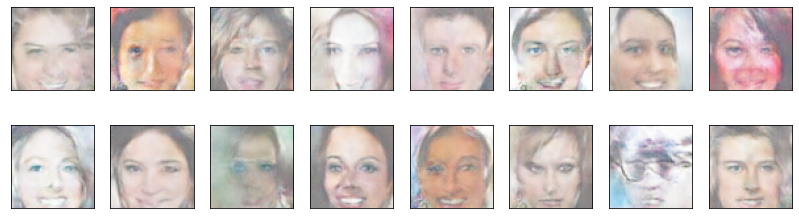

In [77]:
fixed_latent_vector = torch.randn(16, latent_dim, 1, 1).float().cuda()

losses = []
for epoch in range(n_epochs):
    for batch_i, real_images in enumerate(dataloader):
        #display(real_images)
        real_images = real_images.to(device)        
        
        ####################################
        
        g_loss = generator_step(batch_size, latent_dim)
        
        d_loss = discriminator_step(batch_size, latent_dim, real_images)        
        
        ####################################
        
        if batch_i % print_every == 0:
            # append discriminator loss and generator loss
            d = d_loss['loss'].item()
            g = g_loss['loss'].item()
            losses.append((d, g))
            # print discriminator and generator loss
            time = str(datetime.now()).split('.')[0]
            print(f'{time} | Epoch [{epoch+1}/{n_epochs}] | Batch {batch_i}/{len(dataloader)} | d_loss: {d:.4f} | g_loss: {g:.4f}')
    
    # display images during training
    generator.eval()
    generated_images = generator(fixed_latent_vector)
    display(generated_images)
    generator.train()

### Training losses

Plot the training losses for the generator and discriminator.

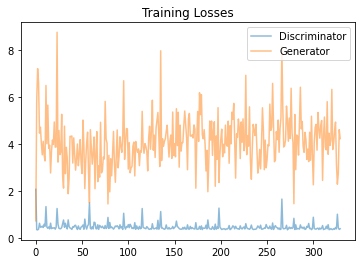

In [78]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result
* Loss functions

**Answer:** I chose a DCGAN architecture and explored different losses: Wasserstein, Wasserstein with Gradient Penalty with lambda=1, lambda=10, BCELoss with learning rate = 0.0002 and 0.0001. BCELoss worked better than the Wasserstein variants. I selected the Adam optimizer. In all variations, I did not see a smoothly decreasing loss function especially for the generator, but fluctuations.The outputs look primarily like white women, similar to the input data of celebrities.

A technical question in detail: to pass the "tests.check_discriminator(discriminator)", I need to add "x = x.unsqueeze(0).unsqueeze(2)" at the end of the discriminator to get a torch.Size([1, 1, 1, 1]) object, but then the training loop crashes. Why is it necessary for the discriminator to produce a torch.Size([1, 1, 1, 1]) object? Why is a torch.Size([1, 1]) object not sufficient, i.e. one vector of logits for each element of the batch?

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb".  

Submit the notebook using the ***SUBMIT*** button in the bottom right corner of the Project Workspace.